In [1]:
import csv
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import sys
import random
import datetime
import traceback

#wow this is a Lot huh. and only growing

I should really make this more modular since I'm gonna be using it many, many times... but since I always end up having to go in and clean up the file lists by hand a little bit anyway, 

Makes list of all files- just fits for now


aia_files = '/home/zenalisa/data/aia/*/*.fits'
hmi_files = '/home/zenalisa/data/hmi/*/*.fits'
table = open('/home/zenalisa/data/AR_list_new.csv', 'w')


aia_file_list = glob.glob(aia_files)
hmi_file_list = glob.glob(hmi_files)

#print len(hmi_file_list)
#print len(aia_file_list) #these don't match- I feel like that might not be a good sign

w = csv.writer(table, delimiter = ',')

for n in range(len(aia_file_list)):
    
    try:
        w.writerow([aia_file_list[n], hmi_file_list[n]])
    except IndexError:
        w.writerow([aia_file_list[n], ''])
        
        break
        
table.close()
#print 'Done'

In [2]:
def fits_to_tiff(filepath, img_type, outp_name=None):

    name, ext = os.path.splitext(filepath)
    
    if not outp_name:
        outp_name = name.replace(name.split('/')[-2], name.split('/')[-2]+'/tiff') #places new files in separate directory
    
    img = fits.open(filepath)
    img.verify('fix')

    #img.info()

    data = img[1].data #has to be img[1]
    width = data.shape[1]
    height = data.shape[0]
    
    
    if img_type == 'aia':
        data = np.log10(data - data.min()+1)
    elif img_type == 'hmi':
        data = abs(data)
        data = data - data.min()
            
    data = data.astype(float)/data.max() * 225 #normalize data and multiply by 225 to map to uint8 values
    
    outputArray = np.array(data, dtype=np.uint8)

    output = Image.fromarray(outputArray.reshape((height, width)), "L")

    if not os.path.exists(outp_name + '/' +  name.split('/')[-2]):
        os.makedirs(outp_name + '/' +  name.split('/')[-2])
    
    output.save(outp_name + '/' +  name.split('/')[-2]+ '/'+ name.split('/')[-1]+".tiff")
    img.close()
    
    return(outp_name + '/' +  name.split('/')[-2]+ '/'+ name.split('/')[-1]+".tiff")

In [3]:
#for sorting file lists by time
def timestamp(filename):
    t = filename.split('/')[-1].split('.')[2]
    return t

In [4]:
def timediff(file1, file2):
    
    try:
        file1_time = file1.split('/')[-1].split('.')[2].split('Z')[0]
        file1_time = datetime.datetime.strptime(file1_time, '%Y-%m-%dT%H%M%S')
    except ValueError:
        file1_time = file1.split('/')[-1].split('.')[2].split('TAI')[0]
        file1_time = datetime.datetime.strptime(file1_time, '%Y%m%d_%H%M%S_')
        
    try:
        file2_time = file2.split('/')[-1].split('.')[2].split('Z')[0]
        file2_time = datetime.datetime.strptime(file2_time, '%Y-%m-%dT%H%M%S')
    except ValueError:
        file2_time = file2.split('/')[-1].split('.')[2].split('TAI')[0]
        file2_time = datetime.datetime.strptime(file2_time, '%Y%m%d_%H%M%S_')
    

    return abs(file1_time - file2_time)
    

In [7]:
#make (and sort and clean up) master lists of files


aia_files = '/mnt/zena/AIA/'
hmi_files = '/mnt/zena/active_regions/'
aia_file_list = []
hmi_file_list = []

regions=[2227, 1503, 1849, 2369, 1106, 2394, 1938, 2101, 2390, 2541] #already used in 190604
newregions = []
#last (newARs):[1298, 2187, 2436]
n = 3
while len(newregions) < n:
    r = random.randint(1076, 2693)
    if os.path.exists(hmi_files+str(r)) and os.path.exists(aia_files+str(r)) and r not in regions:
        #print 'HERE' #if this takes >10s to run, try this- drive may not be mounted
        newregions.append(r)
        
        aia_temp = glob.glob(aia_files+str(r)+'/*.fits')
        aia_temp.sort(key = timestamp)
        hmi_temp = glob.glob(hmi_files+str(r)+'/*.fits')
        hmi_temp.sort(key = timestamp)
        
        if aia_temp == [] or hmi_temp == []:#there seems to be some empty directories... remind me to look into that later
            continue
        
        
        if len(hmi_temp) <= len(aia_temp):
            shortlist = hmi_temp
            longlist = aia_temp
        else:
            shortlist = aia_temp
            longlist = hmi_temp
        
        #print len(longlist), len(shortlist)
        try:
            for i in range(len(shortlist)):
                dt = timediff(shortlist[i], longlist[i])
                j = 0
                while dt > datetime.timedelta(seconds=720):
                    k = i + j
                    del longlist[k]
                    j += 1
                    dt = timediff(shortlist[i], longlist[k+1])
                    #print dt
        
        
        except IndexError:
            pass
            
        #print len(longlist), len(shortlist)
        #break
        for i in range(len(shortlist)):
            #print timediff(shortlist[i], longlist[i])
            try:
                if timediff(shortlist[i], longlist[i]) > datetime.timedelta(seconds=720):
                    del shortlist[i]
                    del longlist[i]
                    continue
                #print timediff(shortlist[i], longlist[i])
        
            except IndexError:
                shortlist = shortlist[:i-1]
                longlist = longlist[:i-1]
                break
        
        #print len(longlist), len(shortlist)
        
        
        #current goal- make sure these two lists only contain images that correspond to an image in the other list
        #before appending them to the master lists.
        if len(longlist) == len(shortlist):
            if 'AIA' in longlist[0]:
                    aia_file_list += longlist
                    hmi_file_list += shortlist
            else:
                    aia_file_list += shortlist
                    hmi_file_list += longlist



print len(hmi_file_list), len(aia_file_list)
print newregions
#last (190604): [2227, 1503, 1849, 2369, 1106, 2394, 1938, 2101, 2390, 2541]

2916 2916
[1298, 2187, 2436]


for a in aia_file_list:
    print a

for i in range(len(shortlist)):
    #print timediff(shortlist[i], longlist[i])
    try:
        if timediff(shortlist[i], longlist[i]) > datetime.timedelta(seconds=720):
            del shortlist[i]
            del longlist[i]
            continue
        #print timediff(shortlist[i], longlist[i])
        
    except IndexError:
        shortlist = shortlist[:i-1]
        longlist = longlist[:i-1]
        break
        
print len(longlist), len(shortlist)

#check if aia and hmi files actually match up 1 to 1 by comparing timestamps
import datetime

for i in range(len(aia_file_list)):
    aia_file = aia_file_list[i]
    hmi_file = hmi_file_list[i]
    
    aia_time = aia_file.split('/')[-1].split('.')[2].split('Z')[0]
    hmi_time = hmi_file.split('/')[-1].split('.')[2].split('TAI')[0]
    
    aia_time = datetime.datetime.strptime(aia_time, '%Y-%m-%dT%H%M%S')
    hmi_time = datetime.datetime.strptime(hmi_time, '%Y%m%d_%H%M%S_')
    print hmi_time - aia_time
    #break
    

 [astropy.io.fits.verify]


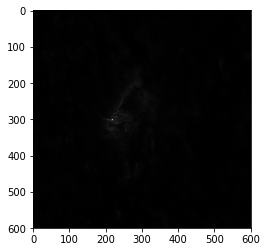

In [2]:
#I don't remember what this one was, just a test hopefully
image_file = "/mnt/zena/AIA/1567/aia.lev1_euv_12s.2012-09-07T235925Z.304.image.fits"

hdu_list = fits.open(image_file)
hdu_list.verify('fix') 
#hdu_list.info()

image_data = hdu_list[1].data

hdu_list.close()

plt.imshow(abs(image_data),cmap='gray')

In [8]:
#check fits files for nan's
aia_file_list_new = []
hmi_file_list_new = []
for n in range(len(aia_file_list)):
    if n%100 == 0:
        print n
    a_fits = fits.open(aia_file_list[n])
    a_fits.verify('fix')
    a = a_fits[1].data
    h_fits = fits.open(hmi_file_list[n])
    h_fits.verify('fix')
    h = h_fits[1].data
    
    a_fits.close()
    h_fits.close()
    
    if np.isnan(a).any() or np.isnan(h).any():
        pass
    else:
        aia_file_list_new.append(aia_file_list[n])
        hmi_file_list_new.append(hmi_file_list[n])
        
    
    

0


 [astropy.io.fits.verify]


100
200
300
400
500
600
700
800


900
1000
1100
1200
1300
1400
1500
1600
1700
1800


1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [9]:
aia_file_list = aia_file_list_new
hmi_file_list = hmi_file_list_new

In [10]:
table = open('/home/zenalisa/data/file_list_newARs.csv', 'w')
#uncomment when we're ready to convert to tiff
w = csv.writer(table, delimiter = ',')
w.writerow(['path_signal', 'path_target'])
i = 0
for n in range(len(aia_file_list)):

    try:
        a = fits_to_tiff(aia_file_list[n], 'aia', outp_name='/home/zenalisa/data/newARs/aia')
        h = fits_to_tiff(hmi_file_list[n], 'hmi', outp_name='/home/zenalisa/data/newARs/hmi')
        
        w.writerow([a, h])

    
    except IndexError: #I don't remember why I had this here?
        pass
    if n%100 ==0:
        print n

        
table.close()
print 'Done'

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Done


In [12]:
#regions = [1109, 1364, 1951, 2013, 2310, 1872, 2017, 2641, 1438] #don't remember what these were used for but it wasnt 190604
#train = open('/home/zenalisa/data/train_list_190604.csv', 'w')
test = open('/home/zenalisa/data/test_list_newARs.csv', 'w')
#biglist = '/home/zenalisa/data/file_list_190322.csv'
#w = csv.writer(train, delimiter = ',')
#w.writerow(['path_signal', 'path_target'])
v = csv.writer(test, delimiter = ',')
v.writerow(['path_signal', 'path_target'])
for r in newregions:
    region_list = glob.glob('/home/zenalisa/data/newARs/aia/'+str(r)+'/*.tiff')
    region_list2 = glob.glob('/home/zenalisa/data/newARs/hmi/'+str(r)+'/*.tiff')
    #nfiles = int(len(region_list)*9./10)
    #trainfilenums = random.sample(range(1, len(region_list)), nfiles)
    #for t in trainfilenums:
    #    a = region_list[t]
    #    h = region_list2[t]
    #    #print a, h
    #    w.writerow([a, h])
    testfilenums = [r for r in range(len(region_list))]# if r not in trainfilenums]
    for t in testfilenums:
        a = region_list[t]
        h = region_list2[t]
        #print a, h
        v.writerow([a, h])

#chooses random image pairs from biglist to use as training images

train = open('/home/zenalisa/data/train_list_2.csv', 'w')

biglist = '/home/zenalisa/data/biglist.csv'

ntrain=560 #number of training images

with open(biglist) as f:
    lines = sum(1 for line in f)
    #print lines #number of files in biglist
    #line_number = random.randrange(lines)
randrows = random.sample(range(1, lines), ntrain)    
#print randrows

#writes paths to randomly chosen training images into table of training images
for r in randrows:
    #print r
    with open(biglist) as f:
        reader = csv.reader(f)
        w = csv.writer(train, delimiter = ',')

        chosen_row = next(row for row_number, row in enumerate(reader)
                          if row_number == r)
        #print chosen_row    
        w.writerow([str(chosen_row[0]), str(chosen_row[1])])


#chooses random testing images from biglist, ensures that they aren't also being used as training images
ntest = 150 #number of testing images
w = csv.writer(test, delimiter = ',')

randrows_test = random.sample(range(1, lines), ntest)
randrows_test = list(set(randrows_test)-set(randrows))
#print len(randrows_test)

while len(randrows_test) < ntest:
    new = random.sample(range(1, lines), 1) #will only return a list, unfortunately. Hence new[0]'s below
    if new[0] not in randrows:
        randrows_test.append(new[0])
    #print len(randrows_test) #for if you want to see it count up 
print len(randrows_test)==ntest #if you don't get True something done goofed

#writes paths to randomly chosen testing images into table of testing images
test = open('/home/zenalisa/data/test_list_2.csv', 'w')
for r in randrows_test:
    #print r
    with open(biglist) as f:
        reader = csv.reader(f)
        w = csv.writer(test, delimiter = ',')

        chosen_row = next(row for row_number, row in enumerate(reader)
                          if row_number == r)
        #print chosen_row    
        w.writerow([str(chosen_row[0]), str(chosen_row[1])])